# Content Based Recommendations with IBM (EXTRA)

This is an extra content of the project "Recommendations with IBM". The work in this notebook is not required; however, it is something interesting to do for a recommendations project!


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

import re 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download(['punkt', 'wordnet', 'stopwords'])

%matplotlib inline

df = pd.read_csv('./data/user-item-interactions.csv')
df_content = pd.read_csv('./data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\loisn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\loisn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\loisn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

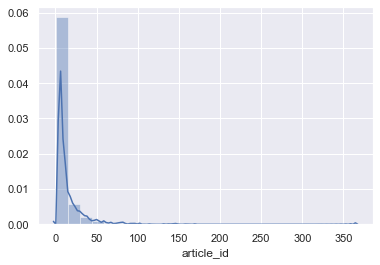

In [3]:
import seaborn as sns
sns.set(color_codes=True)

articles_per_user = df.groupby('email').count()['article_id']
sns.distplot(articles_per_user, bins=25);

In [4]:
df.groupby('email')['article_id'].count().max()

364

In [5]:
# 50% of individuals interact with ____ number of articles or fewer.
median_val = articles_per_user.median() 
median_val

3.0

In [6]:
# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = articles_per_user.max()
max_views_by_user

364

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [7]:
# Find and explore duplicate articles
df_content.nunique()

doc_body           1036
doc_description    1022
doc_full_name      1051
doc_status            1
article_id         1051
dtype: int64

In [8]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [9]:
# a. The number of unique articles that have at least one interaction
df.article_id.nunique()

714

In [10]:
unique_articles = 714

In [11]:
# b. The number of unique articles on the IBM platform
total_articles = df_content.article_id.nunique()
total_articles

1051

In [12]:
# c. The number of unique users
unique_users = df.email.nunique()
unique_users

5148

In [13]:
df.shape

(45993, 3)

In [14]:
# d. The number of user-article interactions
user_article_interactions = len(df)
user_article_interactions

45993

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [15]:
df.groupby('article_id').count().sort_values(by='email', ascending=False).head()

,title,email
article_id,,
1429.0,937,937
1330.0,927,927
1431.0,671,671
1427.0,643,643
1364.0,627,627


In [16]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = '1429.0'

In [17]:
# The most viewed article in the dataset was viewed how many times?
max_views = 937

In [18]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [19]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = list(df.loc[df['article_id'].isin(article_ids),'title'].unique())
    return article_names # Return the article names associated with list of article ids

### <a class="anchor" id="Content-Recs">Part II: Content Based Recommendations</a>

**doc_full_name** is used to hold content for recommendations.


In [20]:
def tokenize(text):
    """
    Tokenizing article titles
    Args: 
        text (str) title
    Return:
        list of word from title
    """
    
    # normalize and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]"," ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    #lemmatize and remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens
             if word not in stop_words]
    
    return tokens
    

In [21]:
def article_content_dataframe(df=df, df_content=df_content):
    """
    INPUT: 
        df - (pandas dataframe) dataframe contains users and articles interaction
        df_content - (pandas dataframe) articles available on the platform
        
    OUTPUT:
        df_total - dataframe contains the total articles 
        article_content - dataframe describes the content of each article on the platform
        
    Description:
        Return a dataframe contains all the articles in the platform with their titles
        Return a dataframe that describes content of articles.
    """
    
    # create dataframe to hold content
    df_init = df[['article_id', 'title']]
    df_content_init = pd.DataFrame({'article_id': df_content.article_id.values,
                                    'title': df_content.doc_full_name})
    
    df_combined = pd.concat([df_init, df_content_init], ignore_index=True)
    df_combined.drop_duplicates(subset=['article_id'], inplace=True)
    df_combined.sort_values(by='article_id', inplace=True)
    df_combined.reset_index(drop=True, inplace=True)
    
    vectorizer = TfidfVectorizer(tokenizer=tokenize)
    df_vec = pd.DataFrame(vectorizer.fit_transform(df_combined.title.values).toarray(),
                         columns=[*vectorizer.vocabulary_])
    
    # concat df_combined and df_vec
    df_articles = pd.concat([df_combined, df_vec], axis=1)
    
    return df_combined, df_articles

df_combined, df_articles = article_content_dataframe()

In [22]:
def article_similarity_dataframe(df=df_articles):
    """
    INPUT:
        df - (pandas dataframe) dataframe describes articles content
        
    OUTPUT:
        article_content - (pandas dataframe) dataframe contains similarity 
    
    Description:
        Return a dataframe that describes similarities between articles
    """
    
    # subset articles content
    article_content = np.array(df_articles.iloc[:, 2:])
    
    # matrix of similarities using dot product 
    dot_prod_article = article_content.dot(np.transpose(article_content))

    # create similarity dataframe
    article_similarity = pd.DataFrame(dot_prod_article,
                                      index=df_articles.article_id,
                                      columns=df_articles.article_id)

    return article_similarity


article_similarity = article_similarity_dataframe()

In [23]:
def top_user_articles(user_id, df=df):
    '''
    INPUT:
        user_id - (int) a user id
        user_item - (pandas dataframe) dataframe of user interaction

    OUTPUT:
        article_ids - (list) a sorted list of the article ids seen by the user

    Description:
        Provides a list of the  article_ids sorted by interactions number
    '''

    df_user = df[df.user_id == 1]
    df_user = df_user.groupby('article_id').count()
    df_user.sort_values('user_id', ascending=False, inplace=True)

    count_article = df_user.user_id.unique()
    article_ids = []
    for k in count_article:
        ids = df_user[df_user.user_id == k].index
        article_ids.append(list(ids))

    return article_ids

In [26]:
def make_content_recs(user_id, m=10, df_sim=article_similarity, thres=1):
    '''
    INPUT:
        user_id - (int) a user id
        m - (int) the number of recommendations you want for the user
        df_sim - (pandas dataframe) pandas dataframe that describe the articles
        similarities using the dot product

    OUTPUT:
        recs - (list) a list of recommendations for the user by article id
        rec_names - (list) a list of recommendations for the user by article title
    '''

    list_ids = top_user_articles(user_id)
    recs = []

    for ids in list_ids:
        top_articles = article_similarity.loc[ids].sum()
        top_articles.sort_values(ascending=False, inplace=True)
        top_articles = top_articles[top_articles >= thres]
        article_not_recs = np.setdiff1d(np.array(top_articles.index),
                                        np.array(recs))
        recs.extend(list(article_not_recs))

        # If there are more than m
        if len(recs) > m:
            break

    recs = recs[:10]
    rec_names = get_article_names(recs, df=df_combined)

    return recs, rec_names

In [27]:
# make recommendations for a brand new user
# make a recommendations for a user who only has interacted with article id '1427.0'

# Get user id who only has interacted with article id '1427.0'
df_1427 = df[df.article_id == 1427.0].groupby('user_id').count()
user_1427 = df_1427.sort_values('article_id').index[0]

# Make recomendation
make_content_recs(user_1427)


([310.0, 585.0, 668.0, 1170.0, 1183.0, 1185.0, 1363.0, 1406.0, 1430.0, 1431.0],
 ['time series prediction using recurrent neural networks (lstms)',
  'tidyverse practice: mapping large european cities',
  'shiny: a data scientist’s best friend',
  'apache spark lab, part 1: basic concepts',
  'categorize urban density',
  'classify tumors with machine learning',
  'predict loan applicant behavior with tensorflow neural networking',
  'uci: iris',
  'using pixiedust for fast, flexible, and easier data analysis and experimentation',
  'visualize car data with brunel'])